<a href="https://colab.research.google.com/github/Bassam-Alswehry/temporal-analysis-of-urban-areas-using-computer-vision-part1/blob/main/temporal_analysis_of_urban_areas_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part1 - Temporal Analysis Of Urban Areas


Goal
Detect and quantify meaningful urban structural changes across time by combining edge-based change detection with structural similarity analysis, while reducing false positives caused by illumination and environmental variations.

Input
- Time-separated satellite images of the same urban location (Before / After)
- Images are aligned and normalized prior to analysis

Output
- Edge-based change maps highlighting structural modifications
- Brightness analysis explaining illumination differences between time periods
- Hybrid change score combining:
  - Edge Change (primary)
  - SSIM-based structural change (secondary)
- Ranked results indicating relative change intensity across locations


In [ ]:
# Cell 1: Imports
import os
import glob
import re

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Cell 2: Paths & basic config

IMAGES_DIR = "data/images"
OUTPUT_DIR = "data/output"
OUTPUT_CSV = os.path.join(OUTPUT_DIR, "part1_results.csv")

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# Cell 3: Image loading & resizing
# Purpose: normalize image size for fair comparison

def load_and_resize(path, size=(640, 360)):
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Could not read image: {path}")
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return img

In [ ]:
# Cell 4: Core change metrics
# Purpose: extract temporal change signal

def compute_change_metrics(img_base_bgr, img_cmp_bgr):
    base_g = cv2.cvtColor(img_base_bgr, cv2.COLOR_BGR2GRAY)
    cmp_g  = cv2.cvtColor(img_cmp_bgr,  cv2.COLOR_BGR2GRAY)

    # Brightness difference (lighting awareness)
    brightness_diff = float(abs(base_g.mean() - cmp_g.mean()))

    # Sharpness (image quality indicator)
    sharpness = float(cv2.Laplacian(cmp_g, cv2.CV_64F).var())

    # Edge-based structural change
    edges1 = cv2.Canny(base_g, 50, 150)
    edges2 = cv2.Canny(cmp_g,  50, 150)
    edge_change = float(np.mean(cv2.absdiff(edges1, edges2)) / 255.0)

    # Lightweight SSIM-like similarity (no external libs)
    mse = np.mean((base_g.astype(np.float32) - cmp_g.astype(np.float32)) ** 2)
    ssim_like = float(1.0 / (1.0 + mse / 1000.0))
    ssim_change = 1.0 - ssim_like

    # Dynamic weighting (robust to lighting)
    if brightness_diff > 25:
        w_edges, w_ssim = 0.90, 0.10
    elif sharpness > 300:
        w_edges, w_ssim = 0.60, 0.40
    else:
        w_edges, w_ssim = 0.75, 0.25

    change_score = float(w_edges * edge_change + w_ssim * ssim_change)

    return {
        "brightness_diff": brightness_diff,
        "sharpness": sharpness,
        "edge_change": edge_change,
        "ssim": ssim_like,
        "ssim_change": ssim_change,
        "w_edges": w_edges,
        "w_ssim": w_ssim,
        "change_score": change_score
    }

In [ ]:
# Cell 5: Filename parsing

pattern = re.compile(
    r"barcelona_(coastal|dense|stable)(\d{2})_(\d{4})\.png",
    re.IGNORECASE
)

all_paths = glob.glob(os.path.join(IMAGES_DIR, "*.png"))

groups = {}
bad_files = []

for path in all_paths:
    name = os.path.basename(path)
    m = pattern.match(name)
    if not m:
        bad_files.append(name)
        continue

    area_type   = m.group(1).lower()
    location_id = m.group(2)          # keep as STRING
    year        = int(m.group(3))

    groups.setdefault((area_type, location_id), []).append((year, path))

for k in groups:
    groups[k] = sorted(groups[k], key=lambda x: x[0])

print("Total images:", len(all_paths))
print("Matched locations:", len(groups))
if bad_files:
    print("Bad filenames:", bad_files[:5])

Total images: 12
Matched locations: 3


In [ ]:
# Cell 6: Build temporal comparison rows
# Baseline = earliest year per location

rows = []

for (area_type, location_id), items in groups.items():
    if len(items) < 2:
        continue

    base_year, base_path = items[0]
    img_base = load_and_resize(base_path)

    for year, path in items[1:]:
        img_cmp = load_and_resize(path)
        mtr = compute_change_metrics(img_base, img_cmp)

        rows.append({
            "area_type": area_type,
            "location_id": location_id,
            "baseline_year": base_year,
            "compared_year": year,
            "baseline_path": os.path.basename(base_path),
            "compared_path": os.path.basename(path),
            "brightness_diff": round(mtr["brightness_diff"], 2),
            "sharpness": round(mtr["sharpness"], 2),
            "edge_change": round(mtr["edge_change"], 4),
            "ssim": round(mtr["ssim"], 4),
            "ssim_change": round(mtr["ssim_change"], 4),
            "w_edges": round(mtr["w_edges"], 2),
            "w_ssim": round(mtr["w_ssim"], 2),
            "change_score": round(mtr["change_score"], 4),
        })

df = pd.DataFrame(rows)
print("Rows collected:", len(df))
df.head()

Rows collected: 9


,area_type,location_id,baseline_year,compared_year,baseline_path,compared_path,brightness_diff,sharpness,edge_change,ssim,ssim_change,w_edges,w_ssim,change_score
0,coastal,01,2014,2018,barcelona_coastal01_2014.png,barcelona_coastal01_2018.png,5.13,681.53,0.2151,0.2122,0.7878,0.60,0.40,0.4442
1,coastal,01,2014,2019,barcelona_coastal01_2014.png,barcelona_coastal01_2019.png,19.25,1019.55,0.2164,0.1766,0.8234,0.60,0.40,0.4592
2,coastal,01,2014,2024,barcelona_coastal01_2014.png,barcelona_coastal01_2024.png,10.53,609.77,0.2179,0.2785,0.7215,0.60,0.40,0.4194
3,stable,03,2014,2015,barcelona_stable03_2014.png,barcelona_stable03_2015.png,12.21,279.61,0.1938,0.5637,0.4363,0.75,0.25,0.2544
4,stable,03,2014,2017,barcelona_stable03_2014.png,barcelona_stable03_2017.png,6.87,345.95,0.2245,0.4004,0.5996,0.60,0.40,0.3746


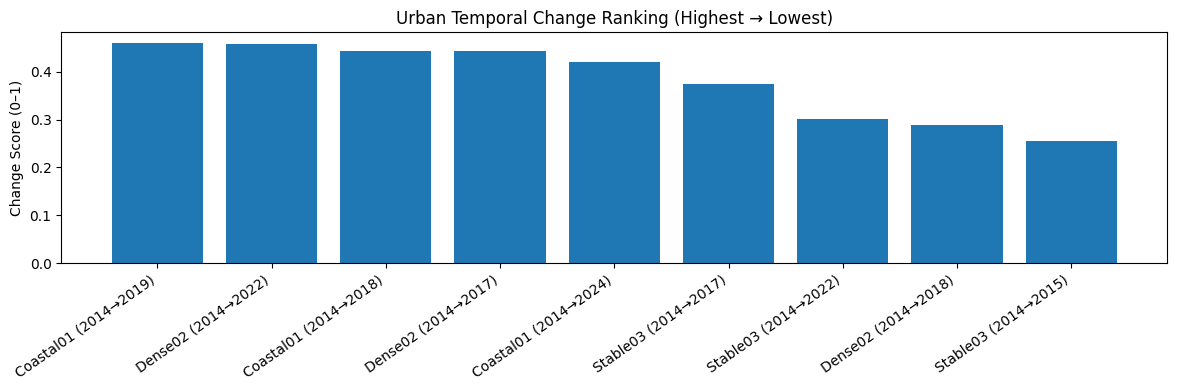

,area_type,location_id,baseline_year,compared_year,baseline_path,compared_path,brightness_diff,sharpness,edge_change,ssim,ssim_change,w_edges,w_ssim,change_score,label
0,coastal,01,2014,2019,barcelona_coastal01_2014.png,barcelona_coastal01_2019.png,19.25,1019.55,0.2164,0.1766,0.8234,0.60,0.40,0.4592,Coastal01 (2014→2019)
1,dense,02,2014,2022,barcelona_dense02_2014.png,barcelona_dense02_2022.png,2.85,846.91,0.2115,0.1752,0.8248,0.60,0.40,0.4568,Dense02 (2014→2022)
2,coastal,01,2014,2018,barcelona_coastal01_2014.png,barcelona_coastal01_2018.png,5.13,681.53,0.2151,0.2122,0.7878,0.60,0.40,0.4442,Coastal01 (2014→2018)
3,dense,02,2014,2017,barcelona_dense02_2014.png,barcelona_dense02_2017.png,9.61,824.39,0.1992,0.1897,0.8103,0.60,0.40,0.4436,Dense02 (2014→2017)
4,coastal,01,2014,2024,barcelona_coastal01_2014.png,barcelona_coastal01_2024.png,10.53,609.77,0.2179,0.2785,0.7215,0.60,0.40,0.4194,Coastal01 (2014→2024)
5,stable,03,2014,2017,barcelona_stable03_2014.png,barcelona_stable03_2017.png,6.87,345.95,0.2245,0.4004,0.5996,0.60,0.40,0.3746,Stable03 (2014→2017)
6,stable,03,2014,2022,barcelona_stable03_2014.png,barcelona_stable03_2022.png,28.93,1287.99,0.2495,0.2390,0.7610,0.90,0.10,0.3006,Stable03 (2014→2022)
7,dense,02,2014,2018,barcelona_dense02_2014.png,barcelona_dense02_2018.png,38.51,1105.42,0.2249,0.1313,0.8687,0.90,0.10,0.2893,Dense02 (2014→2018)
8,stable,03,2014,2015,barcelona_stable03_2014.png,barcelona_stable03_2015.png,12.21,279.61,0.1938,0.5637,0.4363,0.75,0.25,0.2544,Stable03 (2014→2015)


In [ ]:
# Cell 7: Ranking by change score

df_sorted = df.sort_values("change_score", ascending=False).reset_index(drop=True)

df_sorted["label"] = (
    df_sorted["area_type"].str.capitalize()
    + df_sorted["location_id"]
    + " ("
    + df_sorted["baseline_year"].astype(str)
    + "→"
    + df_sorted["compared_year"].astype(str)
    + ")"
)

plt.figure(figsize=(12, 4))
plt.bar(df_sorted["label"], df_sorted["change_score"])
plt.xticks(rotation=35, ha="right")
plt.ylabel("Change Score (0–1)")
plt.title("Urban Temporal Change Ranking (Highest → Lowest)")
plt.tight_layout()
plt.show()

df_sorted

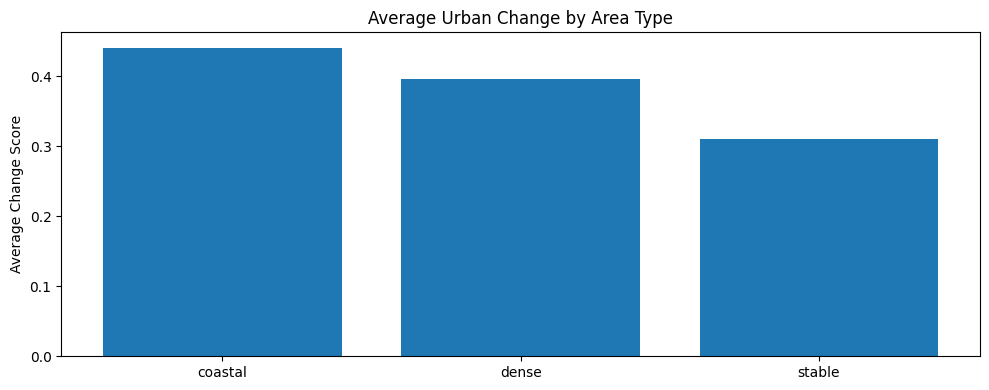

,area_type,avg_change_score
0,coastal,0.440933
1,dense,0.396567
2,stable,0.309867


In [ ]:
# Cell 8: Average change per area type

summary = (
    df_sorted
    .groupby("area_type")["change_score"]
    .mean()
    .reset_index(name="avg_change_score")
)

plt.bar(summary["area_type"], summary["avg_change_score"])
plt.ylabel("Average Change Score")
plt.title("Average Urban Change by Area Type")
plt.tight_layout()
plt.show()

summary

In [ ]:
# Cell 9: Save results

df_sorted.to_csv(OUTPUT_CSV, index=False)
print("Results saved to:", OUTPUT_CSV)

Results saved to: data/output/part1_results.csv


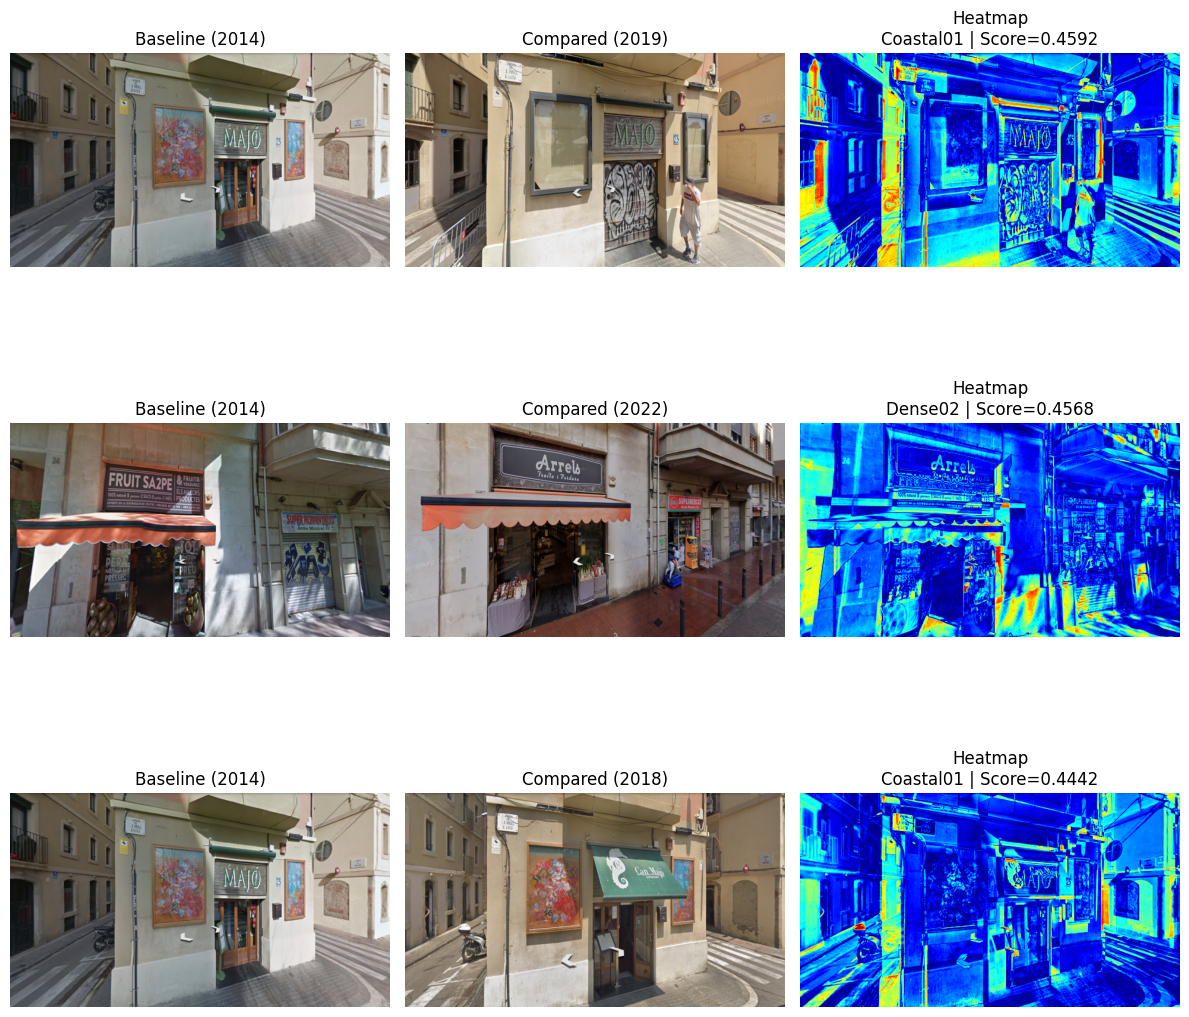

In [ ]:
# Cell 10: Heatmap for Top-3 highest temporal changes
# Purpose: visual inspection of where change is spatially concentrated

TOP_K = 3

top3 = df_sorted.head(TOP_K)

fig, axes = plt.subplots(TOP_K, 3, figsize=(12, 4 * TOP_K))

if TOP_K == 1:
    axes = np.expand_dims(axes, axis=0)

for i, row in top3.iterrows():
    base_img = load_and_resize(os.path.join(IMAGES_DIR, row["baseline_path"]))
    cmp_img  = load_and_resize(os.path.join(IMAGES_DIR, row["compared_path"]))

    base_g = cv2.cvtColor(base_img, cv2.COLOR_BGR2GRAY)
    cmp_g  = cv2.cvtColor(cmp_img,  cv2.COLOR_BGR2GRAY)

    # Absolute difference heatmap
    diff = cv2.absdiff(base_g, cmp_g)

    # Normalize for visualization
    diff_norm = cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX)
    heatmap = cv2.applyColorMap(diff_norm.astype(np.uint8), cv2.COLORMAP_JET)

    axes[i, 0].imshow(cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title(f"Baseline ({row['baseline_year']})")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(cv2.cvtColor(cmp_img, cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title(f"Compared ({row['compared_year']})")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
    axes[i, 2].set_title(
        f"Heatmap\n{row['area_type'].capitalize()}{row['location_id']} | Score={row['change_score']}"
    )
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

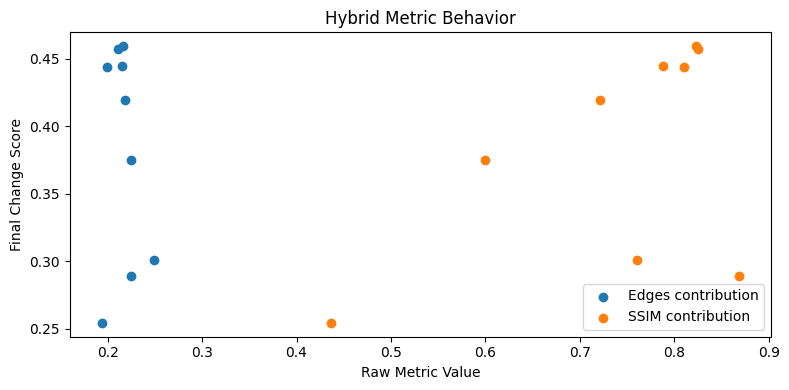

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(df["edge_change"], df["change_score"], label="Edges contribution")
plt.scatter(df["ssim_change"], df["change_score"], label="SSIM contribution")
plt.xlabel("Raw Metric Value")
plt.ylabel("Final Change Score")
plt.title("Hybrid Metric Behavior")
plt.legend()
plt.tight_layout()
plt.show()

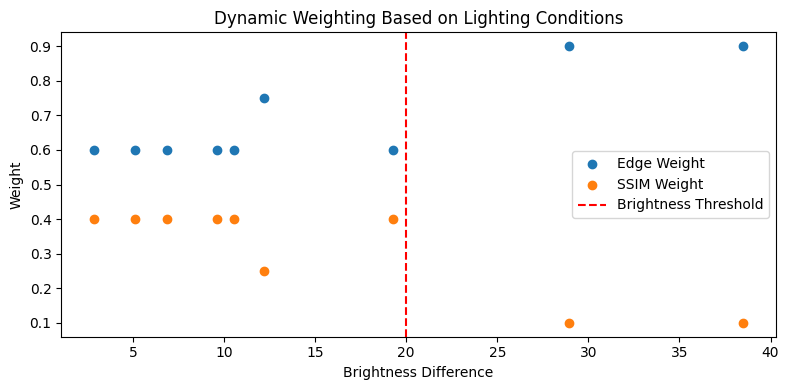

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(df["brightness_diff"], df["w_edges"], label="Edge Weight")
plt.scatter(df["brightness_diff"], df["w_ssim"], label="SSIM Weight")
plt.axvline(20, color="red", linestyle="--", label="Brightness Threshold")
plt.xlabel("Brightness Difference")
plt.ylabel("Weight")
plt.title("Dynamic Weighting Based on Lighting Conditions")
plt.legend()
plt.tight_layout()
plt.show()